In [1]:
from astropy.io import fits
from astropy import units as u
import numpy as np
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from astropy.wcs import WCS
from astropy.modeling import models
from astropy.nddata import StdDevUncertainty
# specutils packages
from specutils import Spectrum1D
from specutils.analysis import line_flux
from specutils.fitting import fit_generic_continuum
from specutils import SpectralRegion
from specutils.analysis import equivalent_width
from specutils.analysis import centroid
from specutils.analysis import moment
from specutils.manipulation import noise_region_uncertainty
from specutils.fitting import estimate_line_parameters
from specutils.manipulation import extract_region
from specutils.fitting import fit_lines
from specutils.fitting import find_lines_threshold
import warnings
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7ff5f0a75040>

In [2]:
# OUR PN
hdu = fits.open("../Spectra-lamostdr7/spec-56581-VB031N50V1_sp08-218.fits")
hdudata = hdu[0].data
wl = hdudata[2]
Flux = hdudata[0]
inve_var = hdudata[1]
sigma = 1 / np.sqrt(inve_var)

In [3]:
# Defining units astropy
rel_flux = u.def_unit('Relative~flux')
rel_flux.decompose()

Unit("Relative~flux")

In [4]:
lamb = wl * u.AA 
flux = Flux * rel_flux
Sigma = StdDevUncertainty(sigma * rel_flux)
spec = Spectrum1D(spectral_axis=lamb, flux=flux, uncertainty=Sigma) 

In [5]:
def extra_line(wl_vacuum):
    line_region = SpectralRegion((wl_vacuum-50)*u.AA, (wl_vacuum+50)*u.AA)
    return line_region

Emission lines

In [6]:
HeII = 4685.99
ArIV = 4740.120
Hbeta = 4862.721
OIII_1 = 4958.911
OIII_2 = 5008.239
ArV = 7005.87
Halpha = 6564.614

In [7]:
extra_Hbeta = extra_line(Hbeta)
Hbeta_spec = extract_region(spec, extra_Hbeta)

Find the line

In [8]:
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
    Hbeta_lines = find_lines_threshold(Hbeta_spec, noise_factor = 3)

In [9]:
Hbeta_lines

line_center,line_type,line_center_index
Angstrom,,
float32,str8,int64
4860.71435546875,emission,43
4867.4345703125,emission,49


In case find more than one line

In [10]:
def closest(lst, K):
    '''find the closest number'''
    lst = np.array(lst)
    idx = (np.abs(lst - K)).argmin()
    return lst[idx]

In [11]:
wl_Hbeta = closest(Hbeta_lines['line_center'], Hbeta)
mask = Hbeta_lines['line_center'] == wl_Hbeta
Hbeta_lines_mask = Hbeta_lines[mask]

Extracting again the region on the line using the line find and estimate the parameters of the Gaussian

In [12]:
Hbeta_region = SpectralRegion(Hbeta_lines_mask['line_center'] - 5 * u.AA, Hbeta_lines_mask['line_center'] + 5 * u.AA)
sub_spectrum = extract_region(spec, Hbeta_region)
line_para = estimate_line_parameters(sub_spectrum, models.Gaussian1D())
line_para

<Gaussian1D(amplitude=2490.39013672 Relative~flux, mean=4860.74414062 Angstrom, stddev=1.5070765 Angstrom)>

Fitting the 1D-Gaussian

In [13]:
# Fit the spectrum and calculate the fitted flux values (``y_fit``)
g_init = models.Gaussian1D(amplitude=line_para.amplitude.value * rel_flux , mean=line_para.mean.value * u.AA , stddev=line_para.stddev.value * u.AA )
g_fit = fit_lines(spec, g_init, window=(Hbeta_lines_mask['line_center'] - 50 * u.AA, Hbeta_lines_mask['line_center'] + 50 * u.AA))
y_fit = g_fit(lamb)

(4833.0, 4893.0)

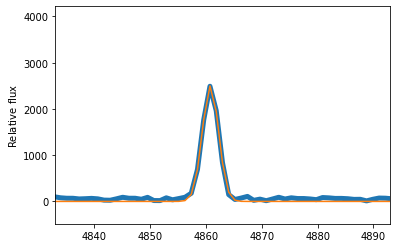

In [14]:
plt.plot(wl, Flux, linewidth=5)
plt.plot(wl, y_fit)
plt.xlim((4863-30), (4863+30))
#plt.xlim(3500, 9000)
#plt.title('Single fit peak window')
#plt.grid(True)

# Helium


In [15]:
extra_HeII = extra_line(HeII)
HeII_spec = extract_region(spec, extra_HeII)

In [16]:
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
    HeII_lines = find_lines_threshold(HeII_spec, noise_factor = 3)

In [17]:
HeII_lines

line_center,line_type,line_center_index
Angstrom,,
float32,str8,int64
4648.36376953125,emission,11
4684.8974609375,emission,45
4705.4384765625,emission,64
4710.85888671875,emission,69
4724.9814453125,emission,82
4731.513671875,emission,88


In [18]:
wl_HeII = closest(HeII_lines['line_center'].value, HeII)
mask_HeII = (HeII_lines['line_center'].value == wl_HeII)
HeII_lines_mask = HeII_lines[mask_HeII]

In [19]:
HeII_region = SpectralRegion(HeII_lines_mask['line_center'] - 5 * u.AA, HeII_lines_mask['line_center'] + 5 * u.AA)
sub_spectrum_HeII = extract_region(spec, HeII_region)
line_para_HeII = estimate_line_parameters(sub_spectrum_HeII, models.Gaussian1D())
line_para_HeII

<Gaussian1D(amplitude=2568.76708984 Relative~flux, mean=4685.32324219 Angstrom, stddev=1.43129992 Angstrom)>

In [20]:
# Fit the spectrum and calculate the fitted flux values (``y_fit``)
g_init_HeII = models.Gaussian1D(amplitude=line_para_HeII.amplitude.value * rel_flux , mean=line_para_HeII.mean.value * u.AA , stddev=line_para_HeII.stddev.value * u.AA )
g_fit_HeII = fit_lines(spec, g_init_HeII, window=(HeII_lines_mask['line_center'] - 5 * u.AA, HeII_lines_mask['line_center'] + 5 * u.AA))
y_fit_HeII = g_fit_HeII(lamb)

(4654.8974609375, 4714.8974609375)

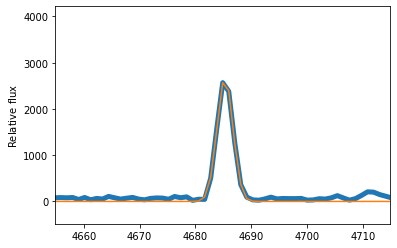

In [21]:
plt.plot(wl, Flux, linewidth=5)
plt.plot(wl, y_fit_HeII)
plt.xlim((HeII_lines_mask['line_center'].value-30), (HeII_lines_mask['line_center'].value+30))

In [22]:
HeII_lines_mask['line_center'] #4685.99

<Quantity [4684.8975] Angstrom>

In [23]:
HeII_lines_mask

line_center,line_type,line_center_index
Angstrom,,
float32,str8,int64
4684.8974609375,emission,45


In [24]:
wl_HeII

4684.8975

### ArIV 

In [25]:
extra_ArIV = extra_line(ArIV)
ArIV_spec = extract_region(spec, extra_ArIV)

In [26]:
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
    ArIV_lines = find_lines_threshold(ArIV_spec, noise_factor = 3)

In [27]:
ArIV_lines

line_center,line_type,line_center_index
Angstrom,,
float32,str8,int64
4705.4384765625,emission,14
4710.85888671875,emission,19
4724.9814453125,emission,32
4731.513671875,emission,38
4740.23779296875,emission,46
4752.25927734375,emission,57


In [28]:
wl_ArIV = closest(ArIV_lines['line_center'].value, ArIV)
mask_ArIV = (ArIV_lines['line_center'].value == wl_ArIV)
ArIV_lines_mask = ArIV_lines[mask_ArIV]

In [29]:
ArIV_region = SpectralRegion(ArIV_lines_mask['line_center'] - 5 * u.AA, ArIV_lines_mask['line_center'] + 5 * u.AA)
sub_spectrum_ArIV = extract_region(spec, ArIV_region)
line_para_ArIV = estimate_line_parameters(sub_spectrum_ArIV, models.Gaussian1D())
line_para_ArIV

<Gaussian1D(amplitude=202.72480774 Relative~flux, mean=4740.18652344 Angstrom, stddev=2.1687839 Angstrom)>

In [30]:
# Fit the spectrum and calculate the fitted flux values (``y_fit``)
g_init_ArIV = models.Gaussian1D(amplitude=line_para_ArIV.amplitude.value * rel_flux , mean=line_para_ArIV.mean.value * u.AA , stddev=line_para_ArIV.stddev.value * u.AA )
g_fit_ArIV = fit_lines(spec, g_init_ArIV, window=(ArIV_lines_mask['line_center'] - 5 * u.AA, ArIV_lines_mask['line_center'] + 5 * u.AA))
y_fit_ArIV = g_fit_ArIV(lamb)

(4710.23779296875, 4770.23779296875)

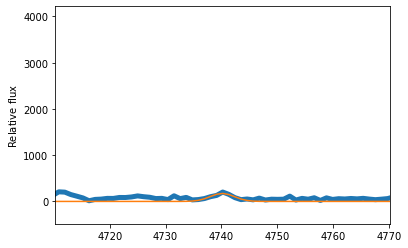

In [31]:
plt.plot(wl, Flux, linewidth=5)
plt.plot(wl, y_fit_ArIV)
plt.xlim((ArIV_lines_mask['line_center'].value-30), (ArIV_lines_mask['line_center'].value+30))

In [32]:
ArIV_lines_mask

line_center,line_type,line_center_index
Angstrom,,
float32,str8,int64
4740.23779296875,emission,46


### ArV

In [33]:
extra_ArV = extra_line(ArV)
ArV_spec = extract_region(spec, extra_ArV)

In [34]:
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
    ArV_lines = find_lines_threshold(ArV_spec, noise_factor = 3)

In [35]:
ArV_lines

line_center,line_type,line_center_index
Angstrom,,
float32,str8,int64
7004.87060546875,emission,30


In [36]:
ArV_region = SpectralRegion(ArV_lines['line_center'] - 5 * u.AA, ArV_lines['line_center'] + 5 * u.AA)
sub_spectrum_ArV = extract_region(spec, ArV_region)
line_para_ArV = estimate_line_parameters(sub_spectrum_ArV, models.Gaussian1D())
line_para_ArV

<Gaussian1D(amplitude=196.99900818 Relative~flux, mean=7004.99072266 Angstrom, stddev=2.98616076 Angstrom)>

In [37]:
g_init_ArV = models.Gaussian1D(amplitude=line_para_ArV.amplitude.value * rel_flux , mean=line_para_ArV.mean.value * u.AA , stddev=line_para_ArV.stddev.value * u.AA )
g_fit_ArV = fit_lines(spec, g_init_ArV, window=(ArV_lines['line_center'] - 5 * u.AA, ArV_lines['line_center'] + 5 * u.AA))
y_fit_ArV = g_fit_ArV(lamb)

(6904.87060546875, 7104.87060546875)

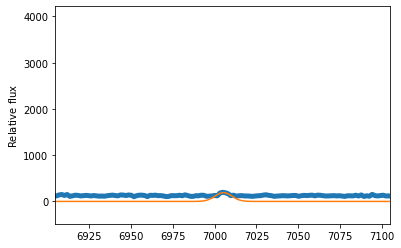

In [38]:
plt.plot(wl, Flux, linewidth=5)
plt.plot(wl, y_fit_ArV)
plt.xlim((ArV_lines['line_center'].value-100), (ArV_lines['line_center'].value+100))